In [34]:
# Notebook investigating using the mca
#https://github.com/bluesky/ophyd/blob/master/ophyd/mca.py

In [118]:
from ophyd.mca import EpicsMCA, ROI

from ophyd import EpicsSignal, EpicsSignalRO
from ophyd import status, DeviceStatus, Signal
from ophyd.status import SubscriptionStatus, MoveStatus, AndStatus 
from collections import OrderedDict

from ophyd.device import (Device, Component as Cpt, DynamicDeviceComponent as DDC,
                     Kind)

class ROI(Device):

    # 'name' is not an allowed attribute
    label = Cpt(EpicsSignal, 'NM', lazy=True, kind='config')
    count = Cpt(EpicsSignalRO, '', lazy=True, kind='hinted')
    net_count = Cpt(EpicsSignalRO, 'N', lazy=True, kind='config')
    preset_count = Cpt(EpicsSignal, 'P', lazy=True, kind='config')
    is_preset = Cpt(EpicsSignal, 'IP', lazy=True, kind='config')
    bkgnd_chans = Cpt(EpicsSignal, 'BG', lazy=True, kind='config')
    hi_chan = Cpt(EpicsSignal, 'HI', lazy=True, kind='config')
    lo_chan = Cpt(EpicsSignal, 'LO', lazy=True, kind='config')

    def __init__(self, prefix, *, read_attrs=None, configuration_attrs=None,
                 name=None, parent=None, **kwargs):

        super().__init__(prefix, read_attrs=read_attrs,
                         configuration_attrs=configuration_attrs,
                         name=name, parent=parent, **kwargs)



class MyEpicsMCA(EpicsMCA):
    
    erase_start = Cpt(EpicsSignal, 'EraseStart', kind='omitted')
    acquiring = Cpt(EpicsSignalRO, '.ACQG', kind='omitted')
    
    
    
    #None of these are consistent enough
    reading = Cpt(EpicsSignalRO, '.READ', kind='omitted')
    readingg = Cpt(EpicsSignalRO, '.RDNG', kind='omitted')
    readings = Cpt(EpicsSignalRO, '.RDNS', kind='omitted')
    
    roi0 =Cpt(ROI, '.R0')
    
    #calibration
    offset = Cpt(EpicsSignalRO, '.CALO',kind='config')
    slope = Cpt(EpicsSignalRO, '.CALS',kind='config')
    quadratic = Cpt(EpicsSignalRO, '.CALQ',kind='config')
    egu = Cpt(EpicsSignalRO, '.EGU',kind='config')
    two_theta = Cpt(EpicsSignalRO, '.TTH',kind='config')
    
    def trigger(self):
        
        callback_signal = self.acquiring
        #variable used as an event flag
        acquisition_status = False
           
        def acquisition_started(status):
            nonlocal acquisition_status #Define as nonlocal as we want to modify it
            acquisition_status = True
                
        def check_value(*, old_value, value, **kwargs):
            #Return True when the acquisition is complete, False otherwise.
                                   
            if not acquisition_status:  #But only report done if acquisition was already started
                
                return False
                       
            return (value == 0 and old_value == 1 and self.preset_real_time.get() == self.elapsed_real_time.get())
        
        # create the status with SubscriptionStatus that add's a callback to check_value.
        sta_cnt = SubscriptionStatus(callback_signal, check_value, run=False, settle_time = 3)
         
        # Start the acquisition
        sta_acq = self.erase_start.set(1)
        
        sta_acq.add_callback(acquisition_started)
        
        stat = AndStatus(sta_cnt, sta_acq)
        
        return stat


bruker = MyEpicsMCA('SISSY2EX:SDD00:mca1',name='bruker')
bruker.wait_for_connection()

In [111]:
# Test to see if the status object that gets returned from trigger changes correctly when finished
    
from datetime import datetime
now = datetime.now().strftime("%H:%M:%S")

def callback(status):
    
    bruker.read()
    now = datetime.now().strftime("%H:%M:%S")
    print(f"{status} has completed at {now}")
    

bruker.enable_wait.set('Disable')
status=bruker.trigger()
now = datetime.now().strftime("%H:%M:%S")
print(f"{status} has started at {now}"  )
status.add_callback(callback)

AndStatus(done=False, success=False) has started at 22:03:03
AndStatus(done=True, success=True) has completed at 22:03:06


Now we will try with the Run Engine


In [88]:
from bluesky import RunEngine

RE = RunEngine({})

from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

#Get the databroker https://gist.github.com/untzag/53281819709b1058c7708a250cbd3676
from databroker.v2 import temp
db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)


1



Transient Scan ID: 22     Time: 2021-10-01 22:10:31
Persistent Unique Scan ID: '3697f75e-5696-4c2b-8ea0-db6da604c866'
New stream: 'primary'
+-----------+------------+-------------------+
|   seq_num |       time | bruker_roi0_count |
+-----------+------------+-------------------+
|         1 | 22:10:46.7 |          99858.00 |
|         2 | 22:11:01.0 |          99876.00 |
|         3 | 22:11:15.3 |          99869.00 |
|         4 | 22:11:29.6 |          99881.00 |
|         5 | 22:11:43.9 |          99872.00 |
|         6 | 22:11:58.2 |          99870.00 |
|         7 | 22:12:12.5 |          99855.00 |
|         8 | 22:12:26.8 |          99855.00 |
|         9 | 22:12:41.1 |          99864.00 |
|        10 | 22:12:55.4 |          99857.00 |
|        11 | 22:13:09.7 |          99879.00 |
|        12 | 22:13:24.2 |          99864.00 |
|        13 | 22:13:38.5 |          99862.00 |
|        14 | 22:13:53.8 |          99866.00 |
|        15 | 22:14:09.2 |          99869.00 |
|        16 

RunEngineInterrupted: 
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.


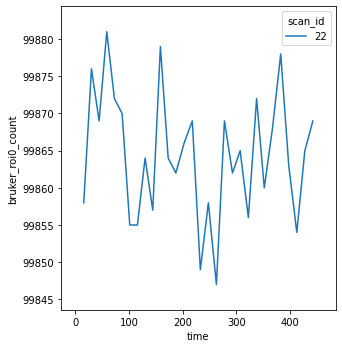

In [119]:
from bluesky.plans import count,scan
from ophyd.sim import motor

#Setting it less than this causes problems!
bruker.preset_real_time.set(10.0)
#We can define which counts we want to display. For now they are in counts and not energy, this is easy to change later
RE(count([bruker],100))

In [79]:
run = db[-1]

run.primary.read()

<xarray.Dataset>
Dimensions:                   (dim_0: 1024, time: 1)
Coordinates:
  * time                      (time) float64 1.633e+09
Dimensions without coordinates: dim_0
Data variables:
    bruker_preset_real_time   (time) float64 1.0
    bruker_elapsed_real_time  (time) float64 1.0
    bruker_spectrum           (time, dim_0) int32 0 0 0 0 0 0 0 ... 0 0 0 0 0 0

In [38]:
# Practice getting the config parameters from the dataset

offset = run.primary.metadata['descriptors'][0]['configuration']['bruker']['data']['bruker_offset']
slope = run.primary.metadata['descriptors'][0]['configuration']['bruker']['data']['bruker_slope']
quadratic = run.primary.metadata['descriptors'][0]['configuration']['bruker']['data']['bruker_quadratic']
egu = run.primary.metadata['descriptors'][0]['configuration']['bruker']['data']['bruker_egu']
two_theta = run.primary.metadata['descriptors'][0]['configuration']['bruker']['data']['bruker_two_theta']

print(offset,slope,quadratic,egu,two_theta)

-538.6077270507812 23.31550407409668 0.0 Wills 10.0


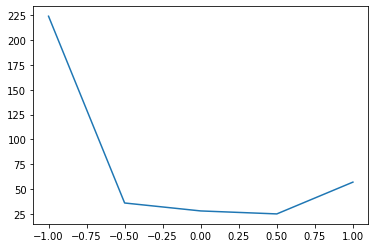

In [76]:
#Practice plotting

data = run.primary.read()
counts = data.bruker_rois_roi0_count
motor_pos = data.motor

import matplotlib.pyplot as plt


plt.plot(motor_pos,counts)



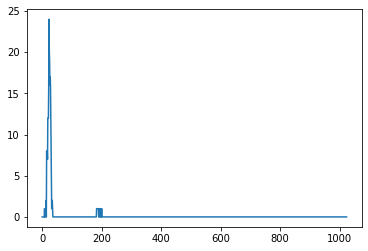

In [66]:
# And practice getting the spectra for a particular entry

import matplotlib.pyplot as plt

spectrum_at_first_sample = data.bruker_spectrum.values[0]
plt.plot(spectrum_at_first_sample)